In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
import mne_connectivity
import glob
import getpass
import importlib
import functions
import spectrogram_plotting_functions
importlib.reload(functions)
importlib.reload(spectrogram_plotting_functions)

<module 'spectrogram_plotting_functions' from 'c:\\Users\\sinha\\Documents\\GitHub\\cpl_analysis_naman\\spectrogram_plotting_functions.py'>

In [2]:

user= (getpass.getuser())
print("Hello", user)

base='C:\\Users\\{}\\Dropbox\\CPLab'.format(user)
files = glob.glob(base+'\\all_data_mat\\*.mat')
savepath = base+'\\results\\'
print(files)

Hello sinha
['C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230529_dk1_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230529_dk3_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230529_dk5_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230529_dk6_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230531_dk1_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230531_dk3_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230531_dk5_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230531_dk6_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230609_dk1_BW_nocontext_day1.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230609_dk3_BW_nocontext_day1.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230610_dk1_BW_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat\\20230610_dk3_BW_nocontext_day2.mat',

In [3]:
keyboard_dict={'98':'b','119':'w','120':'nc','49':'1','48':'0'}

In [4]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#files=[f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat\\20230616_dk6_BW_context_day2.mat']
event_data_df=[]
con_data_df=[]
shuffled_event_data_df=[]
events_codes_all = {}
random_baseline_data=[]
baseline_lfp_all=[]

for file_num,file in enumerate(files):
    #if 'dk1' in file:
        
        print(file)
        base_name = os.path.basename(file)
        base_name, _ = os.path.splitext(base_name)

        date, rat_id, task = functions.exp_params(base_name)
        print(date, rat_id, task)
        if task == 'nocontextday2' or task == 'nocontextos2':
            task = 'nocontext'
        print(date, rat_id, task)

        f = h5py.File(file, 'r')
        channels = list(f.keys())
        print(channels)



        if not any("AON" in channel or "vHp" in channel for channel in channels):
            print("No AON or vHp channels in this file")
            continue

        events,reference_electrode=functions.get_keyboard_and_ref_channels(f,channels)

    #finding global start and end time of all channels, since they start and end recordings at different times
        global_start_time, global_end_time=functions.find_global_start_end_times(f,channels)
        
        ## Reference electrode finding and padding
        reference_time = np.array(reference_electrode['times']).flatten()
        reference_value = np.array(reference_electrode['values']).flatten()
        padd_ref_data,padded_ref_time=functions.pad_raw_data_raw_time(reference_value,reference_time,global_start_time,global_end_time,sampling_rate=2000)

        events_codes = np.array(events['codes'][0])
        events_times = np.array(events['times'][0])
        events_codes_all[base_name] = events_codes
        epochs = functions.generate_epochs_with_first_event(events_codes, events_times)
        #epochs = functions.generate_specific_num_of_epochs_with_first_event(events_codes, events_times,5)
        aon_lfp_channels=[x for x in channels if 'AON' in x ]
        vHp_lfp_channels=[x for x in channels if 'vHp' in x ]
        all_channels=np.concatenate((aon_lfp_channels,vHp_lfp_channels))
        print(all_channels)
        
        mne_baseline_data=np.zeros((1,len(all_channels),4000))
        mne_epoch_door_before=np.zeros((len(epochs),len(all_channels),4000))
        mne_epoch_door_after=np.zeros((len(epochs),len(all_channels),4000))
        mne_epoch_dig_before=np.zeros((len(epochs),len(all_channels),4000))
        mne_epoch_dig_after=np.zeros((len(epochs),len(all_channels),4000))
        
        first_event = events_times[0]
        
        for channel_num,channeli in enumerate(all_channels):
            if "AON" in channeli or "vHp" in channeli:
                channel_id = channeli
                data_all = f[channeli]
                raw_data = np.array(data_all['values']).flatten()
                raw_time = np.array(data_all['times']).flatten()
                sampling_rate = int(1 / data_all['interval'][0][0])
                print(raw_data.shape, raw_time.shape, sampling_rate)
                
                padded_data,padded_time=functions.pad_raw_data_raw_time(raw_data,raw_time,global_start_time,global_end_time,sampling_rate)
                subtracted_data = padded_data - padd_ref_data
                raw_data=subtracted_data
                
                notch_filtered_data = functions.iir_notch(raw_data, sampling_rate, 60)
                
                data_before, time, baseline_mean, baseline_std=functions.baseline_data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)
                normalized_data=functions.zscore_event_data(notch_filtered_data, baseline_mean, baseline_std)

                #baseline_row=[rat_id,task,channel_id,[data_before]]
                #baseline_lfp_all.append(baseline_row)
                #normalized_data, time, data_before = functions.data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)
                baseline_data_truncated= data_before[-4000:]
                
                mne_baseline_data[0,channel_num,:]=list(baseline_data_truncated)
                
                total = normalized_data

                
                for i, epochi in enumerate(epochs):
                    door_timestamp = epochi[0][0]
                    trial_type = epochi[0][1]
                    dig_type = epochi[1, 1]
                    print(dig_type)
                    dig_timestamp = epochi[1, 0]
                    print(door_timestamp, trial_type, dig_timestamp, dig_type)
                    data_complete_trial = functions.extract_complete_trial_data(total, time, door_timestamp, dig_timestamp, sampling_rate)
                    #Here we will extract and store the events data
                    data_door_before,data_door_after=functions.extract_door_data(total, time, door_timestamp, sampling_rate)    
                    data_dig_before, data_dig_after=functions.extract_dig_data(total,time, dig_timestamp, sampling_rate)
                    event_data_list=[data_door_before,data_door_after,data_dig_before,data_dig_after]
                    [functions.zscore_event_data(event_data, baseline_mean ,baseline_std) for event_data in event_data_list]
                    mne_epoch_door_before[i,channel_num,:]=list(event_data_list[0])
                    mne_epoch_door_after[i,channel_num,:]=list(event_data_list[1])
                    mne_epoch_dig_before[i,channel_num,:]=list(event_data_list[2])
                    mne_epoch_dig_after[i,channel_num,:]=list(event_data_list[3])
        if len(all_channels)>0:
            fs=2000
            freqs = np.arange(1,100)
            n_cycles = freqs/2
            info = mne.create_info(ch_names=list(all_channels), sfreq=fs, ch_types='eeg')
            mne_baseline = mne.EpochsArray(mne_baseline_data, info)
            mne_epoch_door_before = mne.EpochsArray(mne_epoch_door_before, info)
            mne_epoch_door_after= mne.EpochsArray(mne_epoch_door_after, info)
            mne_epoch_dig_before = mne.EpochsArray(mne_epoch_dig_before, info)
            mne_epoch_dig_after = mne.EpochsArray(mne_epoch_dig_after, info)
            row_list=[file_num,rat_id,task,mne_baseline,mne_epoch_door_before,mne_epoch_door_after,mne_epoch_dig_before,mne_epoch_dig_after]
            con_data_df.append(row_list)

        # fs=2000
        # freqs = np.arange(1,100)
        # n_cycles = freqs/2
        # info = mne.create_info(ch_names=list(all_channels), sfreq=fs, ch_types='eeg')
        # mne_epoch_door_before = mne.EpochsArray(mne_epoch_door_before, info)
        # mne_epoch_door_after= mne.EpochsArray(mne_epoch_door_after, info)
        # mne_epoch_dig_before = mne.EpochsArray(mne_epoch_dig_before, info)
        # mne_epoch_dig_after = mne.EpochsArray(mne_epoch_dig_after, info)
        # row_list=[rat_id,task,mne_epoch_door_before,mne_epoch_door_after,mne_epoch_dig_before,mne_epoch_dig_after]
        # con_data_df.append(row_list)
#baseline_lfp_all = pd.DataFrame(baseline_lfp_all, columns=['rat', 'experiment', 'channel', 'data'])
con_data_df=pd.DataFrame(con_data_df, columns=['experiment','rat_id','task','mne_baseline','mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after'])


C:\Users\sinha\Dropbox\CPLab\all_data_mat\20230529_dk1_nocontext.mat
20230529 dk1 nocontext
20230529 dk1 nocontext
['Keyboard', 'LFP1_AON', 'LFP1_vHp', 'LFP2_AON', 'LFP2_vHp', 'LFP3_AON', 'LFP4_AON', 'Ref', 'Respirat', 'file']
['LFP1_AON' 'LFP2_AON' 'LFP3_AON' 'LFP4_AON' 'LFP1_vHp' 'LFP2_vHp']
(1516022,) (1516022,) 2000
notch filter applied
normalizing data
49.0
181.20385499999998 120.0 182.713855 49.0
48.0
237.771855 120.0 239.46185499999999 48.0
49.0
279.551855 120.0 280.29184999999995 49.0
48.0
348.953855 120.0 349.84385 48.0
49.0
466.78984999999994 120.0 468.25985499999996 49.0
49.0
526.9038549999999 120.0 528.223855 49.0
49.0
570.771855 120.0 571.4418549999999 49.0
48.0
617.237855 120.0 618.4178549999999 48.0
49.0
669.49786 120.0 670.737855 49.0
49.0
705.3358549999999 120.0 706.5758549999999 49.0
(1516022,) (1516022,) 2000
notch filter applied
normalizing data
49.0
181.20385499999998 120.0 182.713855 49.0
48.0
237.771855 120.0 239.46185499999999 48.0
49.0
279.551855 120.0 280.2918

(8, 7)
trial_epoch
dk1 BWnocontext
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing 

C:\Users\Thomas\AppData\Local\Temp\ipykernel_71336\1352160794.py:28: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


c:\Users\Thomas\anaconda3\envs\lfp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1902.93it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\Thomas\AppData\Local\Temp\ipykernel_71336\1352160794.py:39: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1979.89it/s]

[Connectivity computation done]
trial_epoch
dk1 BWnocontext
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4



C:\Users\Thomas\AppData\Local\Temp\ipykernel_71336\1352160794.py:28: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1883.79it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5



C:\Users\Thomas\AppData\Local\Temp\ipykernel_71336\1352160794.py:39: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1831.84it/s]

[Connectivity computation done]
trial_epoch
dk5 BWnocontext
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4



C:\Users\Thomas\AppData\Local\Temp\ipykernel_71336\1352160794.py:28: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2107.54it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6



C:\Users\Thomas\AppData\Local\Temp\ipykernel_71336\1352160794.py:39: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2063.60it/s]

[Connectivity computation done]
trial_epoch
dk6 BWnocontext
[0]
[1, 2]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (1); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6



C:\Users\Thomas\AppData\Local\Temp\ipykernel_71336\1352160794.py:28: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2840.67it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (1)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral de


C:\Users\Thomas\AppData\Local\Temp\ipykernel_71336\1352160794.py:39: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2279.06it/s]

[Connectivity computation done]
trial_epoch
dk5 BWnocontext
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8



C:\Users\Thomas\AppData\Local\Temp\ipykernel_71336\1352160794.py:28: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1959.65it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5



C:\Users\Thomas\AppData\Local\Temp\ipykernel_71336\1352160794.py:39: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1960.03it/s]

[Connectivity computation done]
trial_epoch
dk6 BWnocontext
[0]
[1, 2]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (1); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7



C:\Users\Thomas\AppData\Local\Temp\ipykernel_71336\1352160794.py:28: RuntimeWarning: There were no Annotations stored in <EpochsArray | 19 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 19>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2130.41it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (1)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10



C:\Users\Thomas\AppData\Local\Temp\ipykernel_71336\1352160794.py:39: RuntimeWarning: There were no Annotations stored in <EpochsArray | 19 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 19>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2000.05it/s]

[Connectivity computation done]
trial_epoch
dk5 BWnocontext
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)



C:\Users\Thomas\AppData\Local\Temp\ipykernel_71336\1352160794.py:28: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2020.76it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6



C:\Users\Thomas\AppData\Local\Temp\ipykernel_71336\1352160794.py:39: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1781.19it/s]

[Connectivity computation done]
trial_epoch
dk5 BWnocontext
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2



C:\Users\Thomas\AppData\Local\Temp\ipykernel_71336\1352160794.py:28: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1921.00it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3



C:\Users\Thomas\AppData\Local\Temp\ipykernel_71336\1352160794.py:39: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1884.61it/s]

[Connectivity computation done]


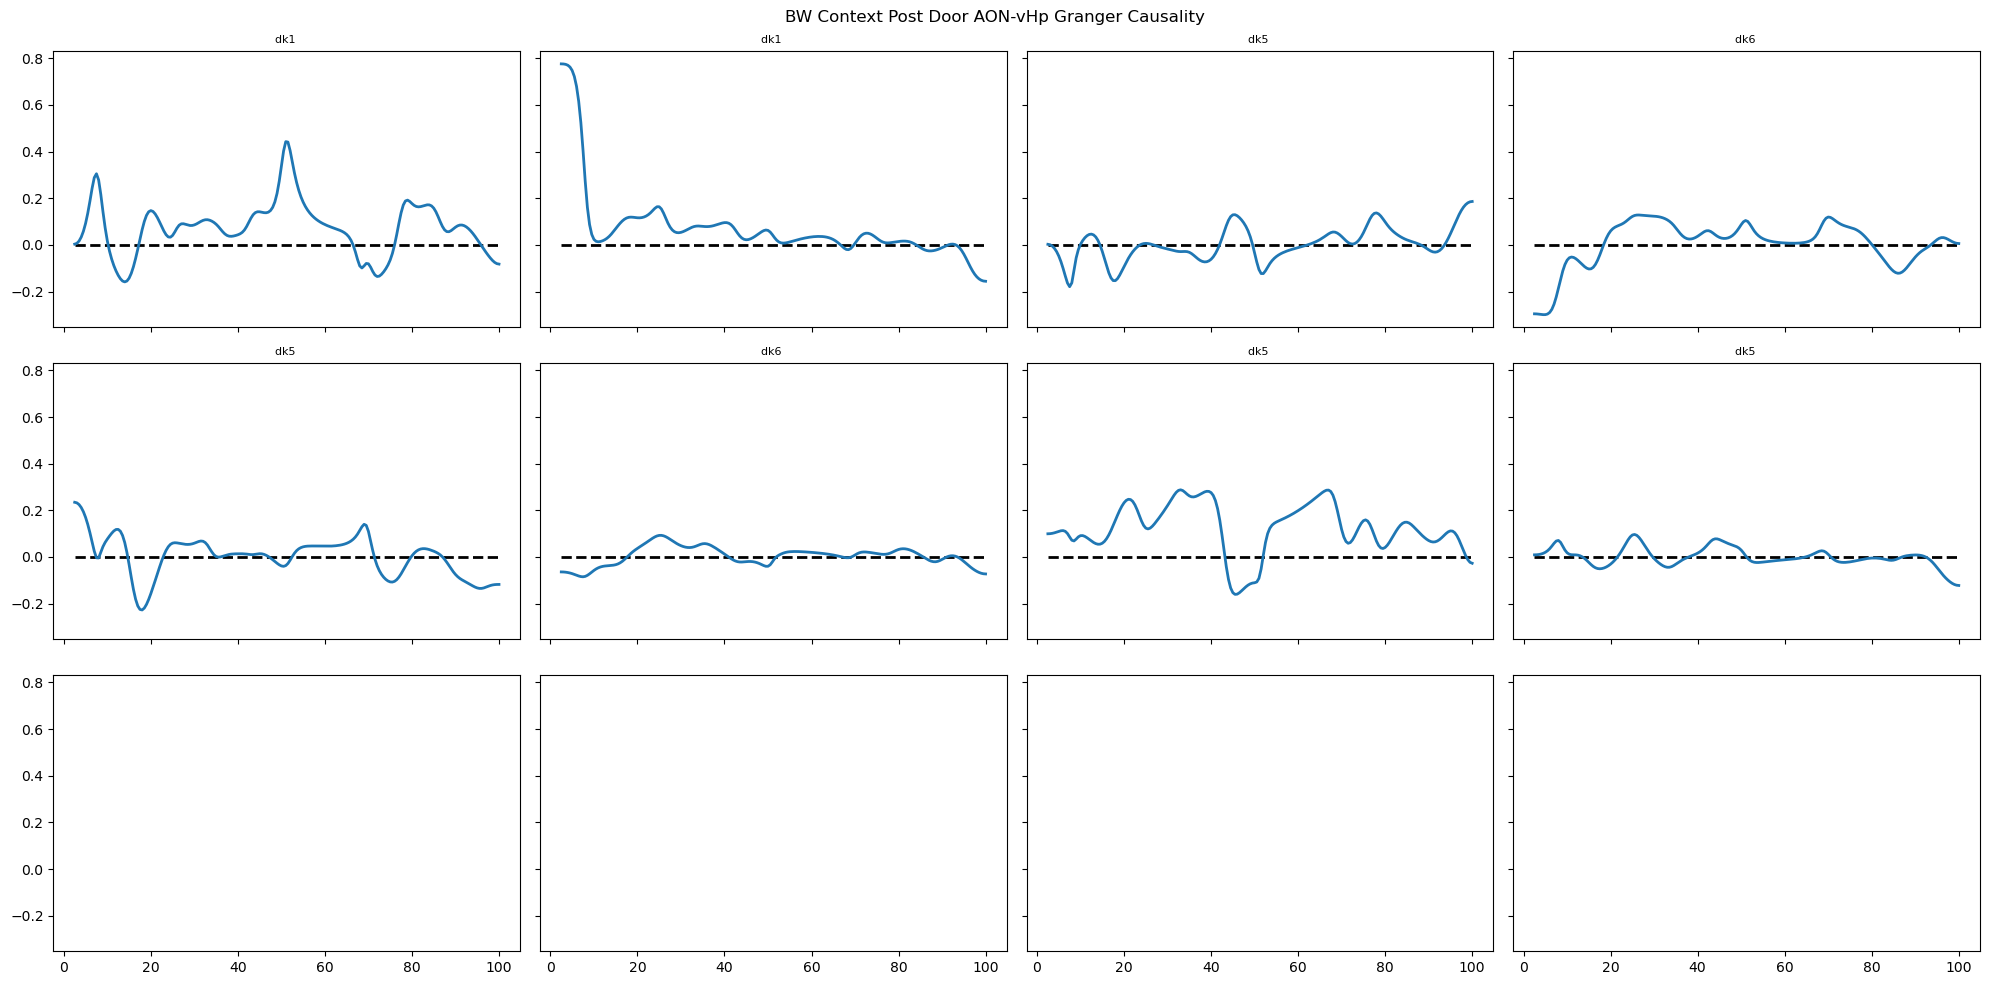

In [5]:
con_data_df=pd.DataFrame(con_data_df, columns=['rat_id','task','mne_baseline','mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after'])

BWcontext_data=con_data_df[(con_data_df['task']=='BWnocontext') & (con_data_df['rat_id']!='dk3')]
print(BWcontext_data.shape)
fig,axs=plt.subplots(3,4, sharex=True, sharey=True, figsize=(20,10))
axs=axs.flatten()
fig.suptitle('BW Context Post Door AON-vHp Granger Causality')
for trial in range(BWcontext_data.shape[0]):
    trial_epoch=BWcontext_data['mne_epoch_door_after'].iloc[trial]
    print("trial_epoch")
    trial_id =f"{BWcontext_data['rat_id'].iloc[trial]} {BWcontext_data['task'].iloc[trial]}"
    print(trial_id)
    aon_signals=[
        idx
        for idx, ch_info in enumerate(trial_epoch.info["chs"])
        if "AON" in ch_info["ch_name"]
    ]
    print(aon_signals)
    vhp_signals=[
        idx
        for idx, ch_info in enumerate(trial_epoch.info["chs"])
        if "vHp" in ch_info["ch_name"]
    ]
    print(vhp_signals)

    indices_aon_vhp = (np.array([aon_signals]), np.array([vhp_signals]))
    indices_vhp_aon = (np.array([vhp_signals]), np.array([aon_signals]))
    gc_ab = mne_connectivity.spectral_connectivity_epochs(
        trial_epoch,
        method=["gc"],
        indices=indices_aon_vhp,
        fmin=2.5,
        fmax=100,
        rank=None,
        gc_n_lags=20,
    )
    freqs = gc_ab.freqs

    gc_ba = mne_connectivity.spectral_connectivity_epochs(
        trial_epoch,
        method=["gc"],
        indices=indices_vhp_aon,
        fmin=2.5,
        fmax=100,
        rank=None,
        gc_n_lags=20,
    )
    freqs = gc_ba.freqs

    net_gc = gc_ab.get_data() - gc_ba.get_data()  # [A => B] - [B => A]
    ax=axs[trial]
    ax.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
    ax.plot(freqs, net_gc[0], linewidth=2)
    ax.set_title(f"{BWcontext_data['rat_id'].iloc[trial]} ", fontsize=8)
fig.tight_layout()
#fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\BWnocontext_post_door_aon_vhp_gc.png')

In [5]:
con_data_df=pd.DataFrame(con_data_df, columns=['rat_id','task','mne_baseline','mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after'])
con_data_df_clean=con_data_df[con_data_df['rat_id']!='dk3']


events_dict={'mne_epoch_door_before':'door before','mne_epoch_door_after':'door after','mne_epoch_dig_before':'dig before','mne_epoch_dig_after':'dig after'}

def calculate_net_gc(mne_data):
        aon_signals=[
        idx
        for idx, ch_info in enumerate(mne_data.info["chs"])
        if "AON" in ch_info["ch_name"]
        ]
        print(aon_signals)
        vhp_signals=[
            idx
            for idx, ch_info in enumerate(mne_data.info["chs"])
            if "vHp" in ch_info["ch_name"]
        ]
        print(vhp_signals)

        indices_aon_vhp = (np.array([aon_signals]), np.array([vhp_signals]))
        indices_vhp_aon = (np.array([vhp_signals]), np.array([aon_signals]))

        gc_ab = mne_connectivity.spectral_connectivity_epochs(
        mne_data,
        method=["gc"],
        indices=indices_aon_vhp,
        fmin=2.5,
        fmax=100,
        rank=None,
        gc_n_lags=20,
        )
        freqs = gc_ab.freqs

        gc_ba = mne_connectivity.spectral_connectivity_epochs(
            mne_data,
            method=["gc"],
            indices=indices_vhp_aon,
            fmin=2.5,
            fmax=100,
            rank=None,
            gc_n_lags=20,
        )
        freqs = gc_ba.freqs

        net_gc = gc_ab.get_data() - gc_ba.get_data()
        return net_gc[0], freqs

gc_data_df=pd.DataFrame()
gc_data_df['rat_id']=con_data_df_clean['rat_id']
gc_data_df['task']=con_data_df_clean['task']
gc_data_df['door_before']=con_data_df_clean['mne_epoch_door_before'].apply(lambda x: calculate_net_gc(x)[0])
gc_data_df['door_after']=con_data_df_clean['mne_epoch_door_after'].apply(lambda x: calculate_net_gc(x)[0])
gc_data_df['dig_before']=con_data_df_clean['mne_epoch_dig_before'].apply(lambda x: calculate_net_gc(x)[0])
gc_data_df['dig_after']=con_data_df_clean['mne_epoch_dig_after'].apply(lambda x: calculate_net_gc(x)[0])

gc_data_df['freqs']=con_data_df_clean['mne_epoch_dig_after'].apply(lambda x: calculate_net_gc(x)[1])

gc_data_df=pd.DataFrame(gc_data_df, columns=['rat_id','task','door_before','door_after','dig_before','dig_after', 'freqs'])



[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
c:\Users\sinha\anaconda3\envs\lfp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1666.36it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2051.91it/s]


[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 9 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 9>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1723.09it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 9 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 9>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2193.12it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1715.77it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1780.56it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1445.87it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2014.63it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1636.94it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1721.59it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1780.49it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1784.43it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cro


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4214.67it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3636.41it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1833.15it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral de


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2853.27it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4134.06it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4031.26it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3391.01it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3464.61it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3665.65it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3522.51it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2833.76it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3127.87it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3516.83it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2681.92it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cro


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3799.26it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3290.40it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cro


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3117.41it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2468.46it/s]

[Connectivity computation done]
[0]
[1, 2]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (1); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4957.36it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (1)
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2463.55it/s]


[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3159.41it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    compu

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3032.53it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cro


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3286.19it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1829.30it/s]


[Connectivity computation done]
[0]
[1, 2]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (1); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-

C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 19 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 19>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4734.36it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (1)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 19 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 19>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4487.87it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1539.80it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1381.06it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1937.38it/s]

[Connectivity computation done]
Connectivity computation...



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1577.84it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
Computing GC for connection 1 of 1



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 4 events (all good), 0 – 2 s (baseline off), ~761 kB, data loaded,
 '1': 4>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1917.70it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 4 events (all good), 0 – 2 s (baseline off), ~761 kB, data loaded,
 '1': 4>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1558.10it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 7 events (all good), 0 – 2 s (baseline off), ~1.3 MB, data loaded,
 '1': 7>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1681.28it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
Computing GC for connection 1 of 1



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 7 events (all good), 0 – 2 s (baseline off), ~1.3 MB, data loaded,
 '1': 7>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1135.19it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1785.54it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1549.06it/s]


[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cro

C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3469.66it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    compu

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2062.74it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cro


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4637.88it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2080.52it/s]


[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3091.24it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
Computing GC for connection 1 of 1


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2080.27it/s]


[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3135.64it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2490.22it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4145.36it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3106.89it/s]


[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1768.30it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1246.86it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 9 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 9>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1557.32it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
Computing GC for connection 1 of 1


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 9 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 9>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1557.55it/s]


[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1899.33it/s]

[Connectivity computation done]
Connectivity computation...



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1774.03it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1784.52it/s]

[Connectivity computation done]
Connectivity computation...



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1032.86it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2028.15it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1380.17it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1745.68it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1663.16it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cro


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2492.86it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    compu

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2669.24it/s]


[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cro

C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3026.32it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    compu

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4123.63it/s]

[Connectivity computation done]



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4117.25it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    compu

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2496.04it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4110.56it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3116.47it/s]


[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2075.31it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    compu

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3995.76it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2726.70it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral de


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3116.60it/s]


[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2494.93it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    compu

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3116.62it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3403.34it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    compu

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3099.73it/s]

[Connectivity computation done]


[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4644.78it/s]


[Connectivity computation done]


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3119.34it/s]

[Connectivity computation done]



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


[0]
[1, 2]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (1); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
  

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4132.84it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (1)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4166.96it/s]


[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3100.35it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    compu

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3135.56it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    compu

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3741.66it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2094.60it/s]

[Connectivity computation done]
[0]
[1, 2]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (1); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 19 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 19>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 6174.67it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 19 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 19>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    connection 1 - seeds (2); targets (1)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    compu

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2081.38it/s]


[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1675.40it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1242.98it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1023.12it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1373.48it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
Computing GC for connection 1 of 1



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 4 events (all good), 0 – 2 s (baseline off), ~761 kB, data loaded,
 '1': 4>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1523.35it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
Computing GC for connection 1 of 1



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 4 events (all good), 0 – 2 s (baseline off), ~761 kB, data loaded,
 '1': 4>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1615.79it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 7 events (all good), 0 – 2 s (baseline off), ~1.3 MB, data loaded,
 '1': 7>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1091.81it/s]

[Connectivity computation done]



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 7 events (all good), 0 – 2 s (baseline off), ~1.3 MB, data loaded,
 '1': 7>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1469.88it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1273.34it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1096.99it/s]

[Connectivity computation done]


[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    compu

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3061.24it/s]


[Connectivity computation done]
Connectivity computation...


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2239.34it/s]


[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3434.89it/s]

[Connectivity computation done]



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3349.46it/s]


[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3229.28it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 2
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3251.21it/s]


[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1875.11it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3085.04it/s]

[Connectivity computation done]


[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2470.58it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral de

C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3132.93it/s]


[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1634.73it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1342.41it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 9 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 9>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1573.14it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 9 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 9>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1150.54it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1453.91it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1421.55it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1224.65it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1666.08it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1501.15it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1350.84it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1430.50it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1131.19it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3777.52it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2487.34it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3751.05it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3084.41it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cro


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3086.15it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3135.74it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cro


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4147.41it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3052.06it/s]


[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2491.37it/s]

[Connectivity computation done]



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4175.68it/s]


[Connectivity computation done]


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2986.34it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4070.33it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3411.86it/s]

[Connectivity computation done]
Connectivity computation...



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3131.25it/s]


[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3135.86it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3091.34it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for e

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4164.07it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3116.72it/s]


[Connectivity computation done]
[0]
[1, 2]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (1); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 6113.19it/s]

[Connectivity computation done]
Connectivity computation...



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (1)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 6183.50it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4147.16it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3111.45it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3133.56it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4164.87it/s]

[Connectivity computation done]
[0]
[1, 2]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 19 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 19>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


Estimated data ranks:
    connection 1 - seeds (1); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4180.97it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (1)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 19 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 19>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 6195.05it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1785.57it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2093.21it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1784.71it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1419.36it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 4 events (all good), 0 – 2 s (baseline off), ~761 kB, data loaded,
 '1': 4>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1444.70it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
Computing GC for connection 1 of 1



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 4 events (all good), 0 – 2 s (baseline off), ~761 kB, data loaded,
 '1': 4>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1653.43it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 7 events (all good), 0 – 2 s (baseline off), ~1.3 MB, data loaded,
 '1': 7>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1809.86it/s]

[Connectivity computation done]
Connectivity computation...



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 7 events (all good), 0 – 2 s (baseline off), ~1.3 MB, data loaded,
 '1': 7>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1710.80it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1839.68it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1789.25it/s]

[Connectivity computation done]



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3553.83it/s]

[Connectivity computation done]
Connectivity computation...



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3559.76it/s]


[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    compu

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3594.01it/s]

[Connectivity computation done]



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3666.84it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1917.75it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3624.93it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3562.78it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3407.61it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    compu

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3879.97it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3816.46it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1561.01it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1657.34it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
Computing GC for connection 1 of 1



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 9 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 9>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2041.72it/s]


[Connectivity computation done]


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 9 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 9>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1375.57it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1795.13it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1481.63it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1969.35it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1850.67it/s]


[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1610.97it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1857.35it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1724.29it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1617.96it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cro


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3594.45it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2357.07it/s]


[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for e

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3768.28it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    compu

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3880.15it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3690.64it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3791.02it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3019.99it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4143.46it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4330.52it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3135.62it/s]


[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3116.75it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    compu

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4147.20it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4142.11it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3135.62it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    compu

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3097.42it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3423.32it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4181.08it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3115.86it/s]

[Connectivity computation done]
[0]
[1, 2]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (1); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4146.01it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (1)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 6194.73it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3111.67it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4181.04it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for e

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3116.56it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2073.62it/s]

[Connectivity computation done]
[0]
[1, 2]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (1); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 19 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 19>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
Computing GC

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 6270.90it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (1)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral de


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 19 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 19>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 6271.62it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1562.47it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1785.55it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1563.02it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1546.82it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
Computing GC for connection 1 of 1



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 4 events (all good), 0 – 2 s (baseline off), ~761 kB, data loaded,
 '1': 4>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1991.69it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 4 events (all good), 0 – 2 s (baseline off), ~761 kB, data loaded,
 '1': 4>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1785.59it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 7 events (all good), 0 – 2 s (baseline off), ~1.3 MB, data loaded,
 '1': 7>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1766.49it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
Computing GC for connection 1 of 1



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 7 events (all good), 0 – 2 s (baseline off), ~1.3 MB, data loaded,
 '1': 7>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1787.59it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2081.94it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1561.22it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4123.84it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4181.16it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4094.51it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4147.10it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4147.39it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
Computing GC for connection 1 of 1



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2492.49it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3116.34it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4180.82it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3116.22it/s]


[Connectivity computation done]
Connectivity computation...


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3135.63it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1785.59it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1785.03it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
Computing GC for connection 1 of 1



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 9 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 9>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2081.92it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 9 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 9>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2061.46it/s]


[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2093.10it/s]

[Connectivity computation done]
Connectivity computation...



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2079.07it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1820.76it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2442.46it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2081.98it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2081.98it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2077.30it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2081.96it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    compu

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3105.11it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3093.51it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3867.35it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3114.72it/s]

[Connectivity computation done]



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4146.99it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3300.61it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3104.17it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4638.07it/s]


[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3098.62it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral de

C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3084.83it/s]


[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    compu

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4147.25it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4099.88it/s]


[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4180.89it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3096.44it/s]


[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4180.97it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4180.72it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2478.04it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral de


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4180.95it/s]


[Connectivity computation done]
[0]
[1, 2]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (1); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 12543.23it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (1)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral de

C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3637.44it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4117.31it/s]

[Connectivity computation done]



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4115.40it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computin

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3123.64it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3929.05it/s]

[Connectivity computation done]
[0]
[1, 2]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (1); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 19 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 19>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4868.78it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 19 events (all good), 0 – 2 s (baseline off), ~1.7 MB, data loaded,
 '1': 19>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


Estimated data ranks:
    connection 1 - seeds (2); targets (1)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 6220.65it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1957.22it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1700.24it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2084.64it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1778.79it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
Computing GC for connection 1 of 1



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 4 events (all good), 0 – 2 s (baseline off), ~761 kB, data loaded,
 '1': 4>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1785.54it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
Computing GC for connection 1 of 1



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 4 events (all good), 0 – 2 s (baseline off), ~761 kB, data loaded,
 '1': 4>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2073.51it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 7 events (all good), 0 – 2 s (baseline off), ~1.3 MB, data loaded,
 '1': 7>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1558.00it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
Computing GC for connection 1 of 1


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 7 events (all good), 0 – 2 s (baseline off), ~1.3 MB, data loaded,
 '1': 7>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1771.19it/s]

[Connectivity computation done]
[0, 1, 2, 3]
[4, 5]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (4); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1785.00it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (4)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 10 events (all good), 0 – 2 s (baseline off), ~1.8 MB, data loaded,
 '1': 10>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1772.71it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cro


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4146.66it/s]

[Connectivity computation done]
Connectivity computation...



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 1958.21it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4146.97it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    compu

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 2233.66it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4146.10it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
Computing GC for connection 1 of 1



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 2 events (all good), 0 – 2 s (baseline off), ~259 kB, data loaded,
 '1': 2>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(
100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4143.02it/s]

[Connectivity computation done]
[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4181.16it/s]


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 17 events (all good), 0 – 2 s (baseline off), ~2.1 MB, data loaded,
 '1': 17>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
Computing GC for connection 1 of 1


100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3135.78it/s]

[Connectivity computation done]



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:24: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ab = mne_connectivity.spectral_connectivity_epochs(


[0, 1]
[2, 3]
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 4138.85it/s]

[Connectivity computation done]
Connectivity computation...



C:\Users\sinha\AppData\Local\Temp\ipykernel_21500\1190099216.py:35: RuntimeWarning: There were no Annotations stored in <EpochsArray | 20 events (all good), 0 – 2 s (baseline off), ~2.5 MB, data loaded,
 '1': 20>, so metadata was not modified.
  gc_ba = mne_connectivity.spectral_connectivity_epochs(


    computing connectivity for 1 connections
    using t=0.000s..2.000s for estimation (4000 points)
    frequencies: 2.5Hz..100.0Hz (196 points)
Estimated data ranks:
    connection 1 - seeds (2); targets (2)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for 

100%|██████████| frequency blocks : 196/196 [00:00<00:00, 3272.66it/s]

[Connectivity computation done]


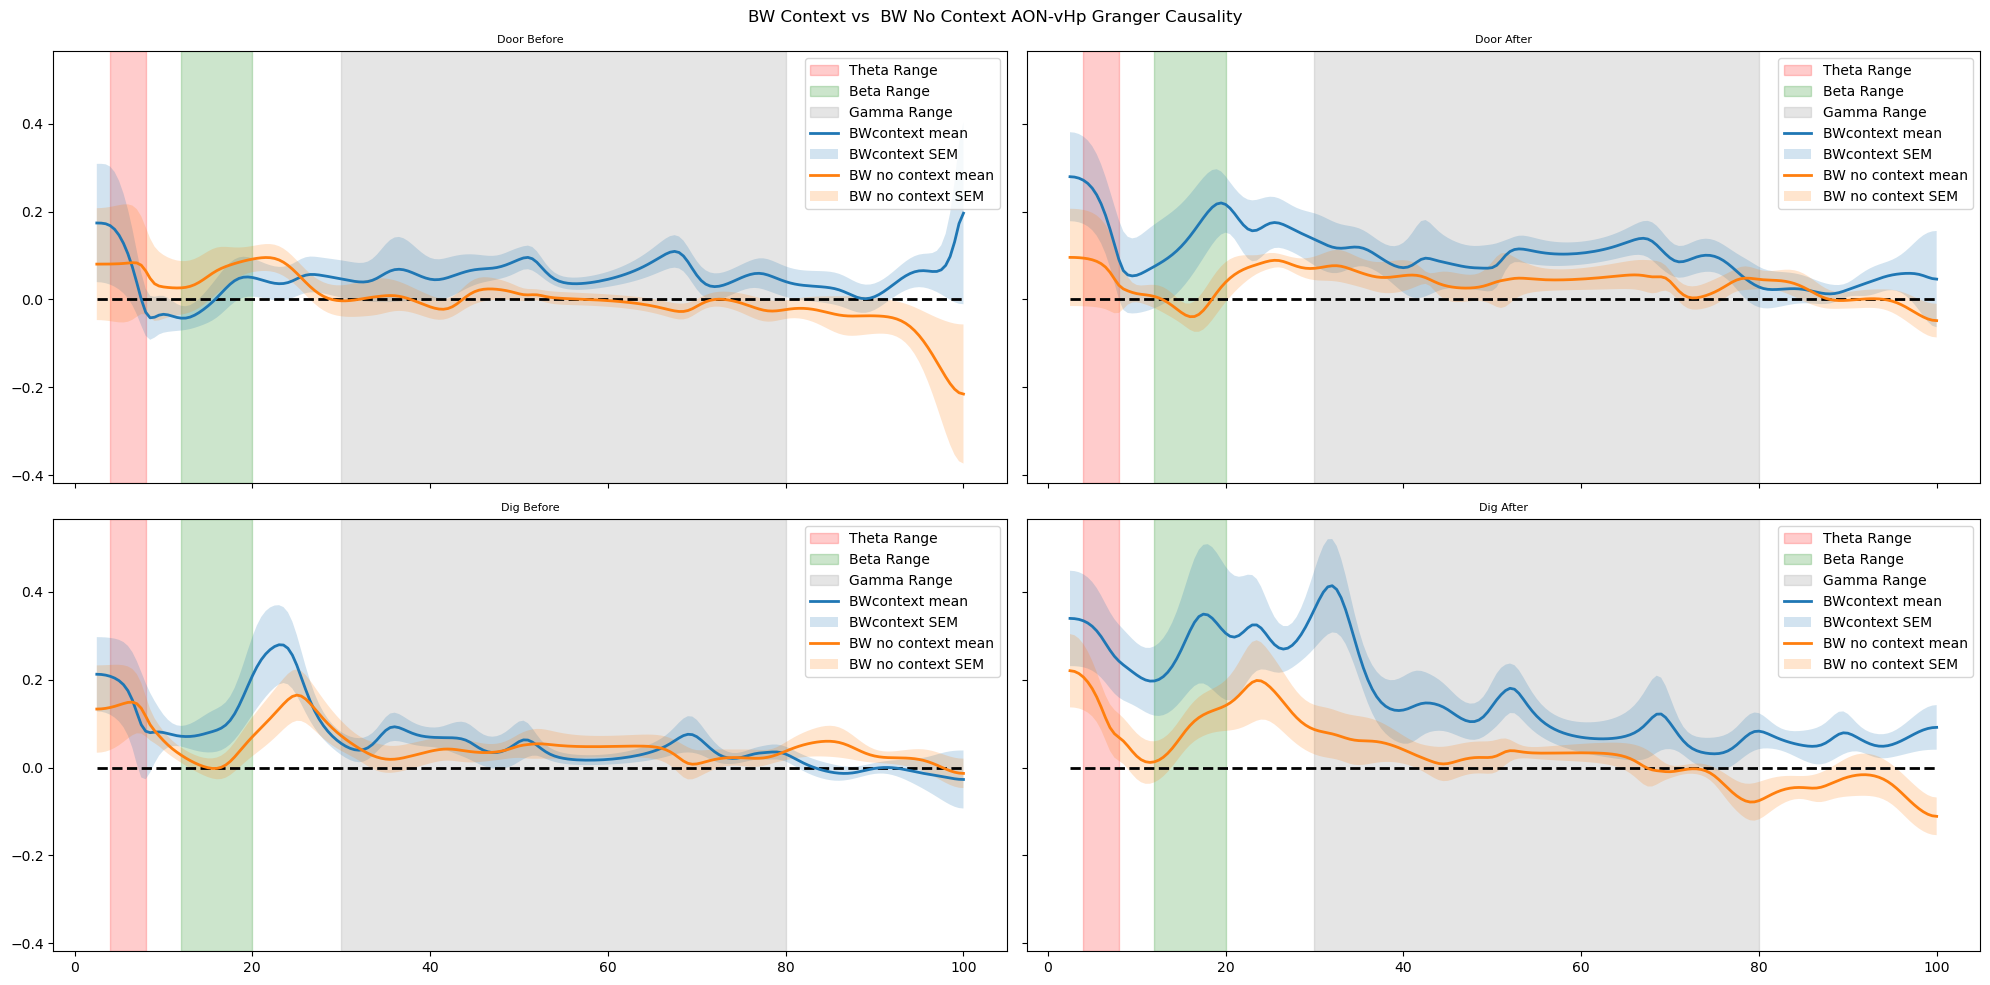

In [7]:
import scipy.stats
gc_data_df_bwcontext=gc_data_df[gc_data_df['task']=='BWcontext']
gc_data_df_bwnocontext=gc_data_df[gc_data_df['task']=='BWnocontext']

fig,axs=plt.subplots(2,2, sharex=True, sharey=True, figsize=(20,10))
axs=axs.flatten()
fig.suptitle('BW Context vs  BW No Context AON-vHp Granger Causality')
events_dict={'door_before': 'Door Before','door_after': 'Door After','dig_before': 'Dig Before','dig_after': 'Dig After'}
for i,event in enumerate(events_dict.keys()):
    ax=axs[i]
    bwcontext_mean=np.mean(gc_data_df_bwcontext[event], axis=0)
    bwnocontext_mean=np.mean(gc_data_df_bwnocontext[event], axis=0)
    bwcontext_sem=scipy.stats.sem(gc_data_df_bwcontext[event], axis=0)
    bwnocontext_sem=scipy.stats.sem(gc_data_df_bwnocontext[event], axis=0)

    ax.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
    ax.axvspan(4,8, alpha=0.2, color='red', label='Theta Range')
    ax.axvspan(12,20, alpha=0.2, color='green', label='Beta Range')
    ax.axvspan(30,80, alpha=0.2, color='grey', label='Gamma Range')
    ax.plot(freqs, bwcontext_mean, linewidth=2, label='BWcontext mean')
    ax.fill_between(freqs, bwcontext_mean - bwcontext_sem, bwcontext_mean + bwcontext_sem, alpha=0.2, label='BWcontext SEM')
    ax.plot(freqs, gc_data_df_bwnocontext[event].mean(), linewidth=2, label='BW no context mean')
    ax.fill_between(freqs, bwnocontext_mean - bwnocontext_sem, bwnocontext_mean + bwnocontext_sem, alpha=0.2, label='BW no context SEM')    
    ax.set_title(f"{events_dict[event]}", fontsize=8)
    ax.legend()
fig.tight_layout()
fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\GC_BWcontext_vs_BWnocontext_AON_vHp.png')
plt.show()

Making Boxplots for GC measures

    rat_id         task        event   band   gcvalue
96     dk1  BWnocontext  door_before  total -0.041306
97     dk1  BWnocontext  door_before  theta  0.216749
98     dk1  BWnocontext  door_before   beta  0.056833
99     dk1  BWnocontext  door_before  gamma -0.046559
100    dk1  BWnocontext   door_after  total  0.037167
..     ...          ...          ...    ...       ...
459    dk1    BWcontext   dig_before  gamma  0.059955
460    dk1    BWcontext    dig_after  total  0.145909
461    dk1    BWcontext    dig_after  theta  0.059968
462    dk1    BWcontext    dig_after   beta  0.316273
463    dk1    BWcontext    dig_after  gamma  0.158614

[288 rows x 5 columns]
0 door_before
1 door_after
2 dig_before
3 dig_after


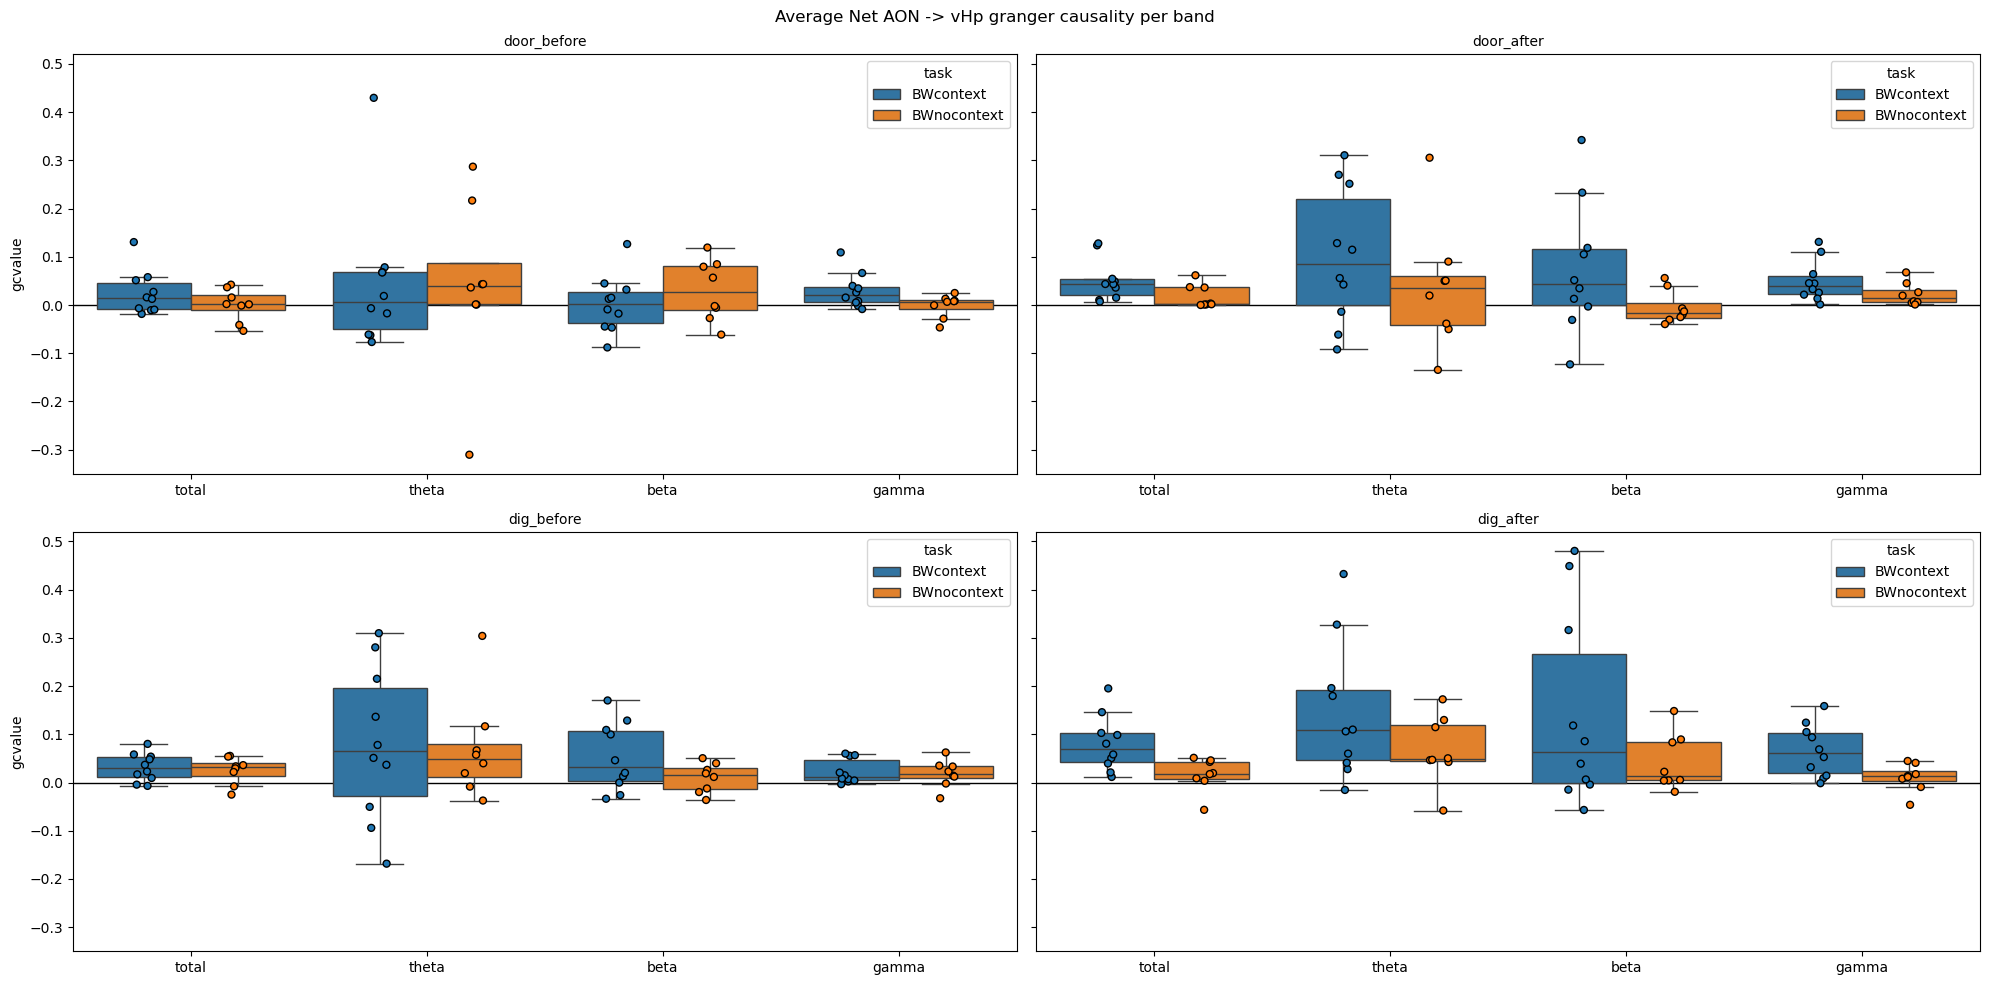

In [22]:
import numpy as np
import seaborn as sns
#%matplotlib qt
bands_dict={'total':[2.5,100],'theta': [4,8],'beta':[12,20],'gamma':[30,80]}

def calculate_gc_per_band(gc_array,freqs_array, bands_dict):
    freqs_array = np.array(freqs_array)  # Convert freqs_array to numpy array
    gc_bands_dict={}
    for band in bands_dict.keys():
        band_indices=np.where((freqs_array>=bands_dict[band][0]) & (freqs_array<=bands_dict[band][1]))
        gc_band=gc_array[band_indices]

        gc_bands_dict[band]=(np.sum(gc_band)*0.5)/len(gc_band)

    return gc_bands_dict

test_gc=gc_data_df_bwcontext['door_before'].iloc[0]
test_freqs=gc_data_df_bwcontext['freqs'].iloc[0]
test_gc_band=calculate_gc_per_band(test_gc,test_freqs, bands_dict)

gc_cols = ['door_before', 'door_after', 'dig_before', 'dig_after']
gc_data_df_bands = []

for index, row in gc_data_df.iterrows():
    rat_id = row['rat_id']
    task = row['task']
    freqs = row['freqs']
    for gc_col in gc_cols:
        gc_values = calculate_gc_per_band(row[gc_col], freqs, bands_dict)
        for band, gc_value in gc_values.items():
            gc_data_df_bands.append({
                'rat_id': rat_id,
                'task': task,
                'event': gc_col,
                'band': band,
                'gcvalue': gc_value
            })

gc_data_df_bands = pd.DataFrame(gc_data_df_bands)
gc_data_df_bands=gc_data_df_bands[gc_data_df_bands['task']!='nocontext']
print(gc_data_df_bands)

fig, axs=plt.subplots(2,2, sharex=False, sharey=True, figsize=(20,10))
axs=axs.flatten()
fig.suptitle('Average Net AON -> vHp granger causality per band')
for i, event in enumerate(gc_cols):
    print(i, event)
    ax=axs[i]
    gc_event=gc_data_df_bands[gc_data_df_bands['event']==event]
    ax.axhline(0, color='black', lw=1)
    sns.boxplot(x='band',y='gcvalue',hue='task',hue_order=['BWcontext','BWnocontext'],data=gc_event,showfliers=False, ax=ax)
    sns.stripplot(x='band',y='gcvalue',hue='task',hue_order=['BWcontext','BWnocontext'],data=gc_event,dodge=True,edgecolor='black',linewidth=1,jitter=True, legend=False, ax=ax)
    ax.set_title(f"{event}", fontsize=10)
    ax.set_xlabel('')
fig.tight_layout()
fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\GC_net_AoN_vHp.png')
plt.show()